In [ ]:
import numpy as np 
import pandas as pd

In [2]:
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score


%matplotlib inline

In [3]:
def pie_plot(column, data=None, title=None, ax=None, fontsize=15, explode=0,
             autopct='%1.1f%%', shadow=None, figsize=(10, 6), colors=None, color_with_label=None):
    if type(column) == str:
        target = data[column].value_counts()
    else:
        target = column.value_counts()
    
    explode = [explode for _ in range(len(target))]
    
    if color_with_label:
        colors = [color_with_label[key] for key in target.index]
        
    if ax is not None:
        if title is not None:
            ax.set_title(title, fontsize=fontsize)

        ax.pie(target, labels=target.index, autopct=autopct, shadow=shadow, explode=explode, colors=colors)
    else:
        fig = plt.figure(figsize=figsize)

        if title is not None:
            plt.title(title, fontsize=fontsize)

        plt.pie(target, labels=target.index, autopct=autopct, shadow=shadow, explode=explode, colors=colors)
        

def bar_plot(column, data=None, title=None, ax=None, fontsize=15, figsize=(10, 6), color='b'):
    if type(column) == str:
        target = data[column].value_counts()
    else:
        target = column.value_counts()
    
    if ax is not None:
        if title is not None:
            ax.set_title(title, fontsize=fontsize)

        ax.bar(target.index, target, color=color)
    else:
        fig = plt.figure(figsize=figsize)

        if title is not None:
            plt.title(title, fontsize=fontsize)

        plt.bar(target.index, target, color=color)
    

def compare_plots(shape, columns, titles=None, data=None, kind='pie', explode=0, color='b',
                  fontsize=15, autopct='%1.1f%%', figsize=(20, 10), shadow=None, color_with_label=True):
    
    fig, axes = plt.subplots(*shape, figsize=figsize)
    
    for i, ax in enumerate(axes.ravel()):
        title = titles[i] if titles is not None else None
        
        if kind == 'pie':
            pie_plot(columns[i], data=data, title=title, ax=ax, fontsize=fontsize, colors=color,
                     autopct=autopct, figsize=figsize, explode=explode, shadow=shadow, 
                     color_with_label=color_with_label)
        elif kind == 'bar':
            bar_plot(columns[i], data=data, title=title, ax=ax, fontsize=fontsize, figsize=figsize, color=color)
        else:
            raise TypeError

def known_vs_unknown(columns, data, unknown=np.nan):
    _data = data.copy()

    for col in columns:
        _data[col] = _data[col].replace(unknown, 'Unknown')
        _data[col][_data[col] != 'Unknown'] = 'Known'
    
    return _data.loc[:, columns]

def compare_models(data, labels, models, scoring="neg_mean_squared_error", cv=10): 
    record = {}
    
    for name, model in models:
        m = model
        model.fit(data, labels)
        predictions = model.predict(data)
        model_mse = mean_squared_error(labels, predictions)
        model_rmse = np.sqrt(model_mse)
        scores = cross_val_score(model, data, labels, scoring=scoring, cv=cv)
        scores = np.sqrt(-scores)
        
        model_record = {
            "model": m,
            "mean_squared_error": model_mse,
            "root_mean_squared_error": model_rmse,
            "scores": scores,
            "scores_mean": scores.mean(),
            "scores_std": scores.std()
        }
        
        record[name] = model_record
    
    return record

In [4]:
house_prices_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv", index_col='Id')
house_prices_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
house_prices_train.shape

(1460, 80)

In [6]:
house_prices_train.duplicated().any()

False

In [7]:
house_prices_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
house_prices_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [1]:
house_prices_train.descr()


This dataset consists of 80 features with their descriptions below:

* **_1stFlrSF_**: Total area of ​​the first floor of the house
* **_2ndFlrSF_**: Total area of ​​the second floor of the house
* **_3SsnPorch_**: Varande area of ​​three seasons (?)
* **_Alley_**: Characteristic of the alley that gives access to housing
* **_BedroomAbvGr_**: Number of beds in the house (above the basement)
* **_BldgType_**: Type of housing
* **_BsmtCond_**: Classifies the basement's general condition
* **_BsmtExposure_**: Exposition of the basement of the dwelling
* **_BsmtFinSF1_**: Area covered by type 1 finish (BsmtFinType1 attribute)
* **_BsmtFinSF2_**: Area covered by type 2 finish (BsmtFinType2 attribute)
* **_BsmtFinType1_**: Score of the finish of the basement-related region
* **_BsmtFinType2_**: Score of the finish of the basement-related region (if more than one exists)
* **_BsmtFullBath_**: Full bathrooms in the basement-related area
* **_BsmtHalfBath_**: Incomplete bathrooms (half) of the

In [9]:
house_prices_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [10]:
continuous_col= list(house_prices_train.describe().columns)
categorical_col = [_d for _d in house_prices_train.columns if _d not in continuous_col]

In [11]:
continuous_data = house_prices_train.loc[:, continuous_col]
categorical_data = house_prices_train.loc[:, categorical_col]

In [12]:
continuous_data.columns, f"Length: {len(continuous_col)}"

(Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
        'MoSold', 'YrSold', 'SalePrice'],
       dtype='object'),
 'Length: 37')

In [13]:
continuous_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1452 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [14]:
cont_d = continuous_data.isnull().any()
missing_continuous = list(cont_d[cont_d == True].index)
missing_continuous

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [15]:
data = known_vs_unknown(missing_continuous, continuous_data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


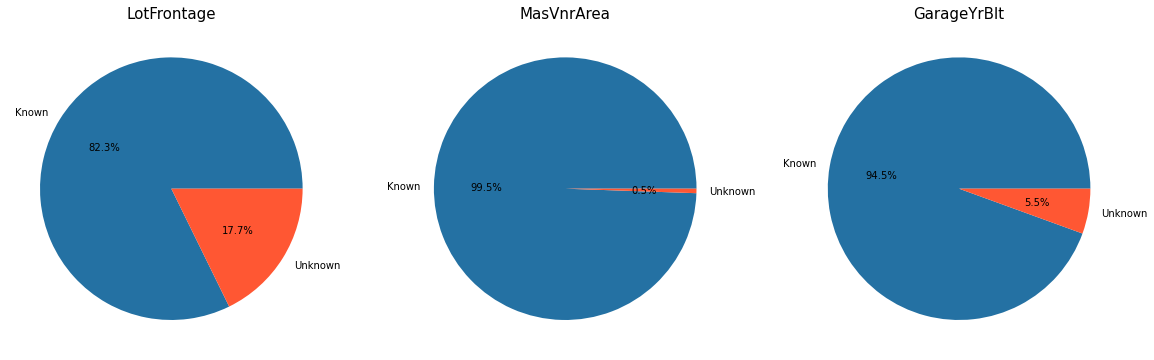

In [16]:
colors = {
    "Unknown": "#FF5733",
    "Known": "#2471A3",
}

compare_plots((1, 3), columns=missing_continuous, titles=missing_continuous, data=data, color_with_label=colors)

In [17]:
labels = continuous_data.SalePrice
continuous_data.drop("SalePrice", axis=1, inplace=True)
continuous_col = list(continuous_data.columns)

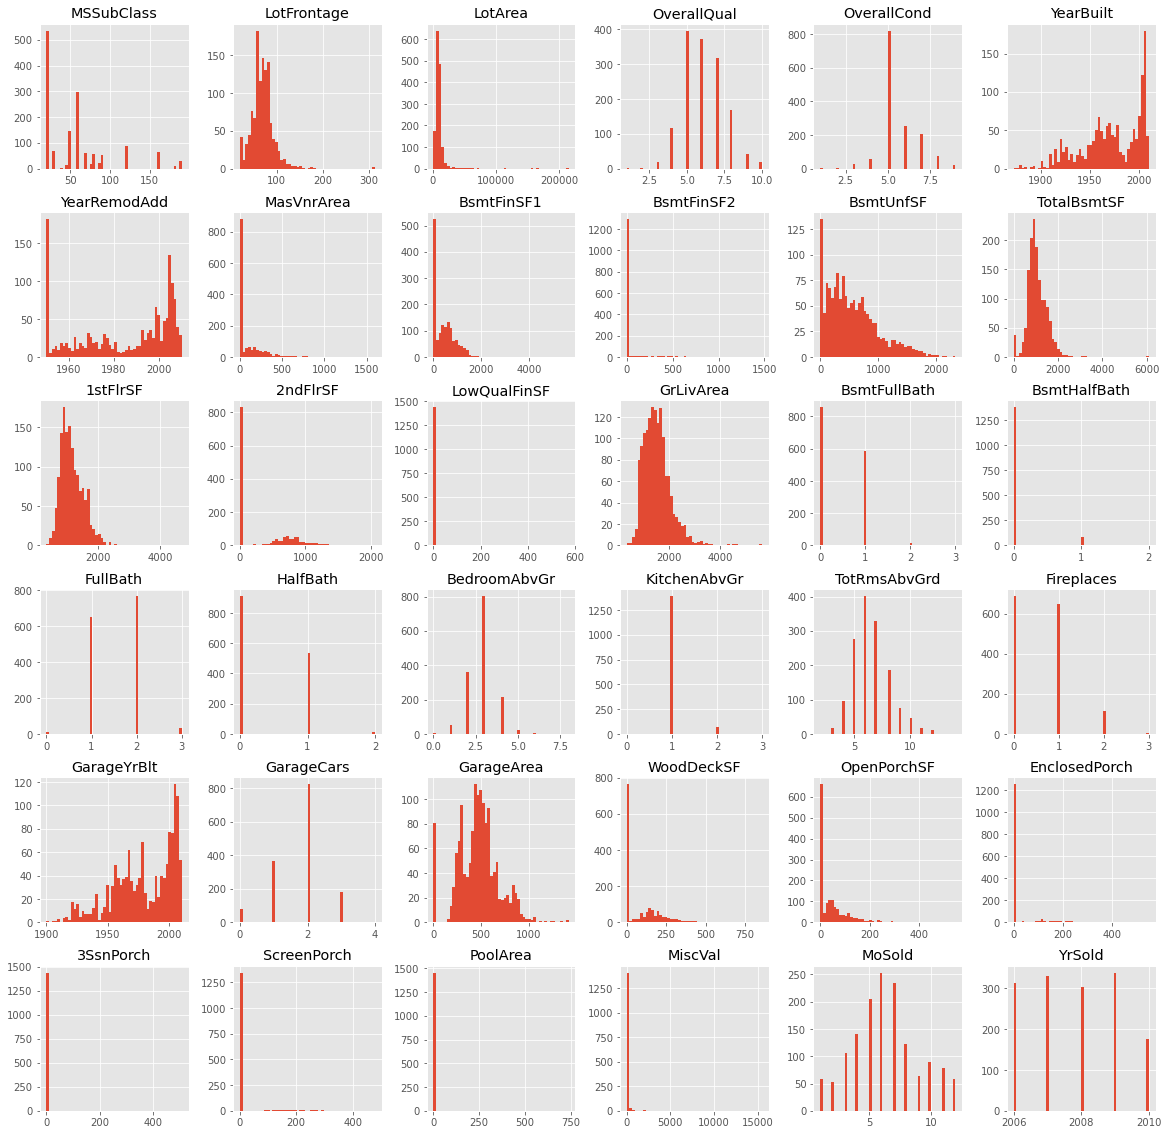

In [18]:
plt.style.use("ggplot")
continuous_data.hist(bins=50, figsize=(20,20))
plt.show()

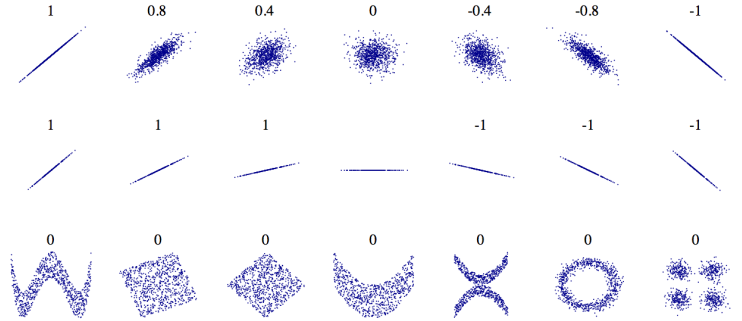

In [19]:
Image("../input/correlation/correlation.png")

In [20]:
corr_matrix = continuous_data.corr()

In [21]:
corr_matrix["YearBuilt"].sort_values(ascending=False)

YearBuilt        1.000000
GarageYrBlt      0.825667
YearRemodAdd     0.592855
OverallQual      0.572323
GarageCars       0.537850
GarageArea       0.478954
FullBath         0.468271
TotalBsmtSF      0.391452
MasVnrArea       0.315707
1stFlrSF         0.281986
BsmtFinSF1       0.249503
HalfBath         0.242656
WoodDeckSF       0.224880
GrLivArea        0.199010
OpenPorchSF      0.188686
BsmtFullBath     0.187599
BsmtUnfSF        0.149040
Fireplaces       0.147716
LotFrontage      0.123349
TotRmsAbvGrd     0.095589
3SsnPorch        0.031355
MSSubClass       0.027850
LotArea          0.014228
MoSold           0.012398
2ndFlrSF         0.010308
PoolArea         0.004950
YrSold          -0.013618
MiscVal         -0.034383
BsmtHalfBath    -0.038162
BsmtFinSF2      -0.049107
ScreenPorch     -0.050364
BedroomAbvGr    -0.070651
KitchenAbvGr    -0.174800
LowQualFinSF    -0.183784
OverallCond     -0.375983
EnclosedPorch   -0.387268
Name: YearBuilt, dtype: float64

In [22]:
corr_matrix["1stFlrSF"].sort_values(ascending=False)

1stFlrSF         1.000000
TotalBsmtSF      0.819530
GrLivArea        0.566024
GarageArea       0.489782
OverallQual      0.476224
LotFrontage      0.457181
BsmtFinSF1       0.445863
GarageCars       0.439317
Fireplaces       0.410531
TotRmsAbvGrd     0.409516
FullBath         0.380637
MasVnrArea       0.344501
BsmtUnfSF        0.317987
LotArea          0.299475
YearBuilt        0.281986
BsmtFullBath     0.244671
YearRemodAdd     0.240379
WoodDeckSF       0.235459
GarageYrBlt      0.233449
OpenPorchSF      0.211671
PoolArea         0.131525
BedroomAbvGr     0.127401
BsmtFinSF2       0.097117
ScreenPorch      0.088758
KitchenAbvGr     0.068101
3SsnPorch        0.056104
MoSold           0.031372
BsmtHalfBath     0.001956
YrSold          -0.013604
LowQualFinSF    -0.014241
MiscVal         -0.021096
EnclosedPorch   -0.065292
HalfBath        -0.119916
OverallCond     -0.144203
2ndFlrSF        -0.202646
MSSubClass      -0.251758
Name: 1stFlrSF, dtype: float64

In [23]:
corr_matrix["GarageArea"].sort_values(ascending=False)

GarageArea       1.000000
GarageCars       0.882475
GarageYrBlt      0.564567
OverallQual      0.562022
1stFlrSF         0.489782
TotalBsmtSF      0.486665
YearBuilt        0.478954
GrLivArea        0.468997
FullBath         0.405656
MasVnrArea       0.373066
YearRemodAdd     0.371600
LotFrontage      0.344997
TotRmsAbvGrd     0.337822
BsmtFinSF1       0.296970
Fireplaces       0.269141
OpenPorchSF      0.241435
WoodDeckSF       0.224666
BsmtUnfSF        0.183303
LotArea          0.180403
BsmtFullBath     0.179189
HalfBath         0.163549
2ndFlrSF         0.138347
BedroomAbvGr     0.065253
PoolArea         0.061047
ScreenPorch      0.051412
3SsnPorch        0.035087
MoSold           0.027974
BsmtFinSF2      -0.018227
BsmtHalfBath    -0.024536
YrSold          -0.027378
MiscVal         -0.027400
KitchenAbvGr    -0.064433
LowQualFinSF    -0.067601
MSSubClass      -0.098672
EnclosedPorch   -0.121777
OverallCond     -0.151521
Name: GarageArea, dtype: float64

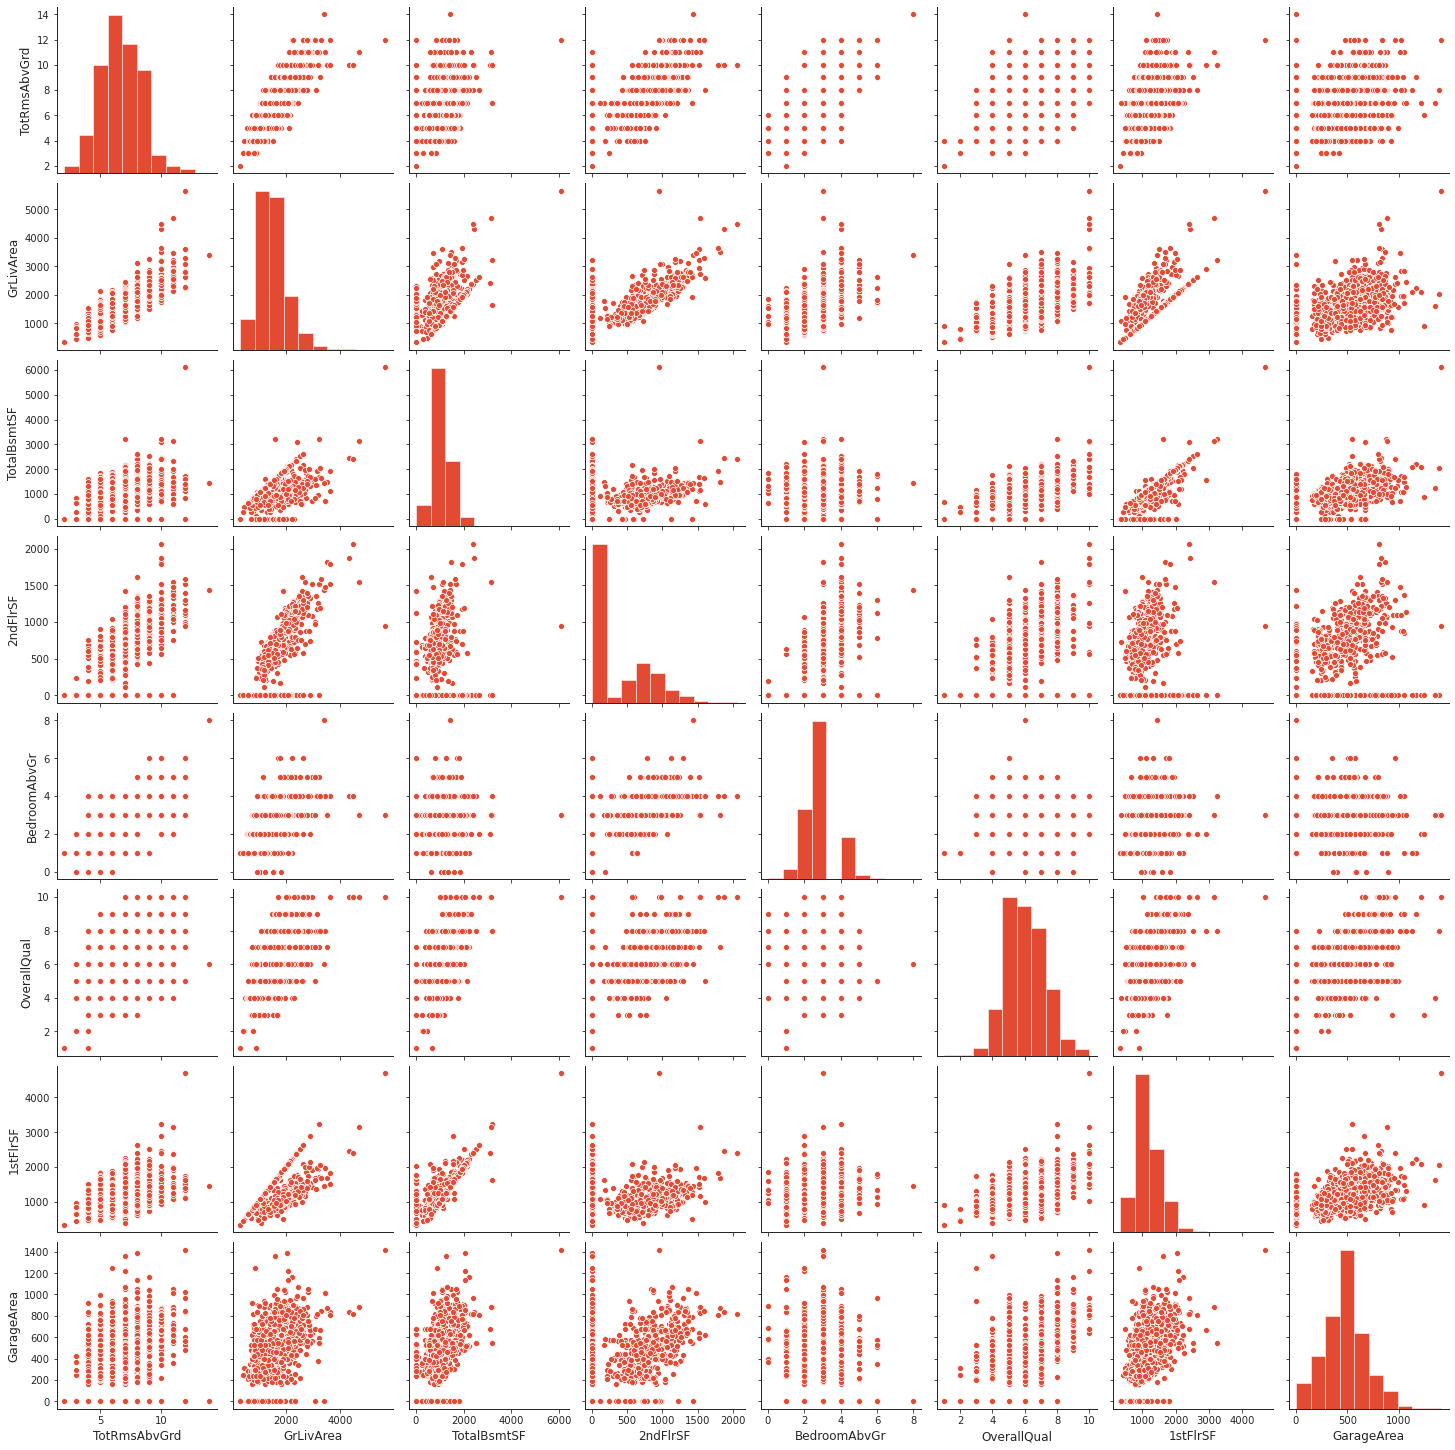

In [24]:
sns.set_style("ticks")
attributes = ["TotRmsAbvGrd", "GrLivArea", "TotalBsmtSF", "2ndFlrSF", "BedroomAbvGr", "OverallQual", "1stFlrSF", 
              "GarageArea"]
sns.pairplot(continuous_data[attributes])

In [25]:
continuous_data_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('num_scaler', StandardScaler()),
])

In [26]:
continuous_data_tr = continuous_data_pipeline.fit_transform(continuous_data)

In [27]:
categorical_data.columns, f"Length: {len(categorical_col)}"

(Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition'],
       dtype='object'),
 'Length: 43')

In [28]:
categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   Alley          91 non-null     object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     1452 non-null   object
 18  ExterQual      1460 non-null

In [29]:
cat_d = categorical_data.isnull().any()
missing_categorical = list(cat_d[cat_d == True].index)
len(missing_categorical), missing_categorical

(16,
 ['Alley',
  'MasVnrType',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Electrical',
  'FireplaceQu',
  'GarageType',
  'GarageFinish',
  'GarageQual',
  'GarageCond',
  'PoolQC',
  'Fence',
  'MiscFeature'])

In [30]:
data = known_vs_unknown(missing_categorical, categorical_data)

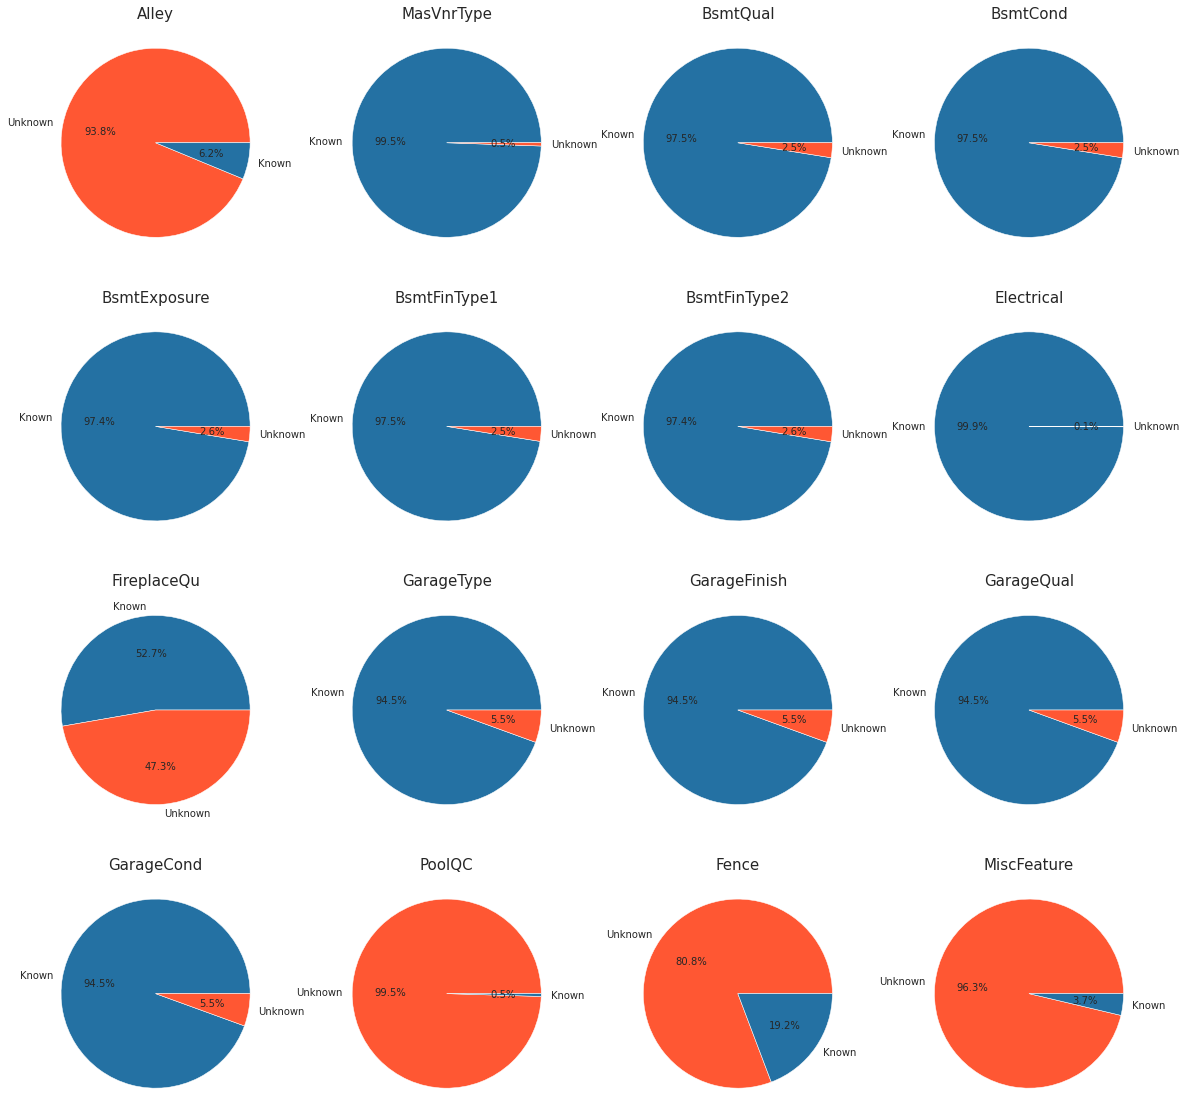

In [31]:
compare_plots((4, 4), columns=missing_categorical, titles=missing_categorical, data=data, 
              figsize=(20, 20), color_with_label=colors)

In [32]:
drop_categorical = ["Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]
categorical_data.drop(drop_categorical, axis=1, inplace=True)
categorical_col = list(categorical_data.columns)

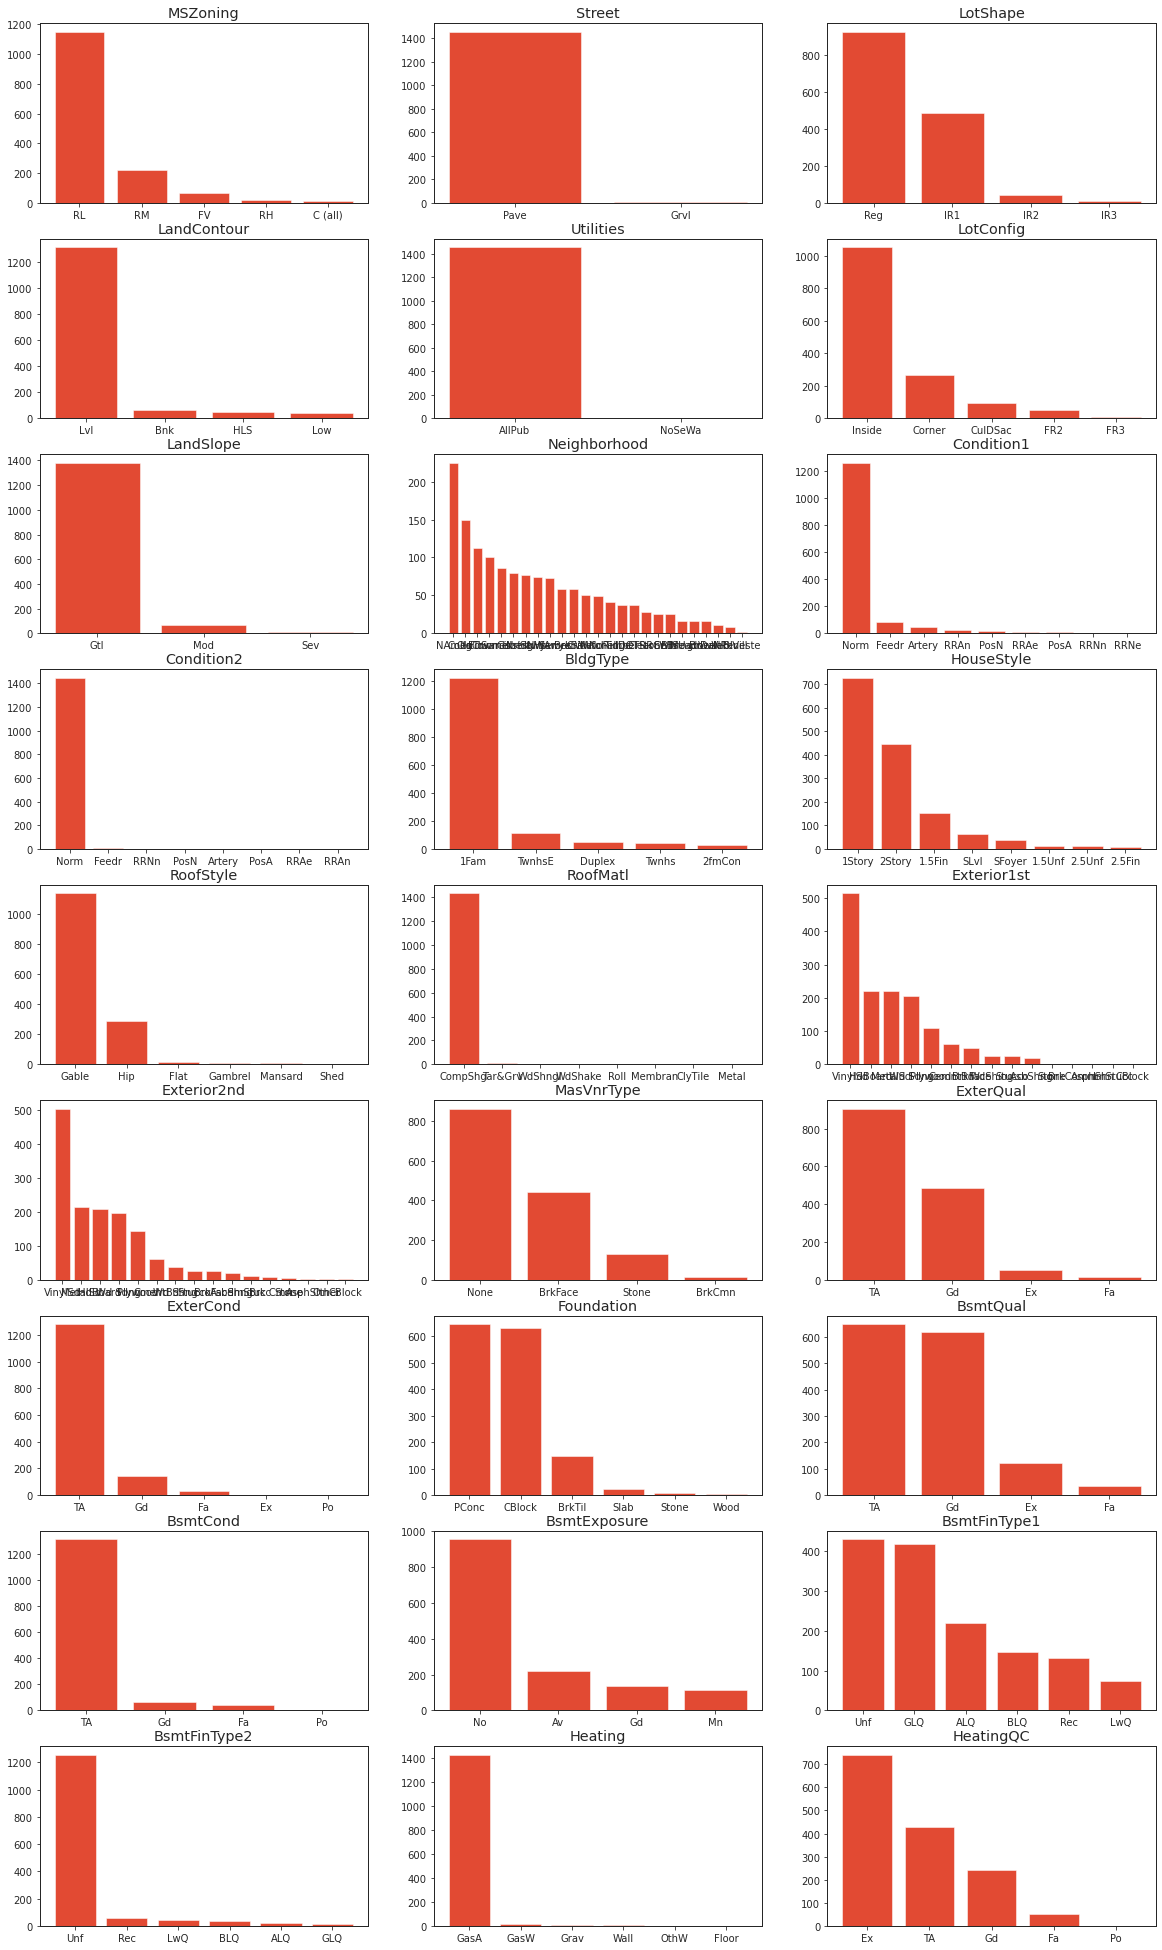

In [33]:
f, axes = plt.subplots(9, 3, figsize=(20, 35))

for ax, col in zip(axes.ravel(), categorical_data.columns):
    target = categorical_data[col].value_counts()
    ax.bar(target.index, target)
    ax.set_title(col)

In [34]:
categorical_data_pipeline = Pipeline([
    ('freq_imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OrdinalEncoder())
])

In [35]:
categorical_data_tr = categorical_data_pipeline.fit_transform(categorical_data)

In [36]:
housing_price_pipeline = ColumnTransformer([
    ("continous", continuous_data_pipeline, continuous_col),
    ("categorical", categorical_data_pipeline, categorical_col),
])

In [37]:
def prepare_data(data, drop_cols, fit_trasform=True):
    data.drop(drop_cols, axis=1, inplace=True)
    if fit_trasform:
        return housing_price_pipeline.fit_transform(data)
    else:
        return housing_price_pipeline.transform(data)

In [38]:
data = house_prices_train.copy()

In [39]:
data = prepare_data(data, drop_categorical + ["SalePrice"])

In [40]:
data.shape

(1460, 74)

In [41]:
lin_reg = LinearRegression()
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()
svm_reg = SVR()

In [42]:
models = zip(
    ["Linear Regression", "Decision Tree Regression", "Random Forest Regression", "Support Vector Regression"],
    [lin_reg, dt_reg, rf_reg, svm_reg]
)

In [43]:
records = compare_models(data, labels, models)

In [44]:
records["Linear Regression"]

{'model': LinearRegression(),
 'mean_squared_error': 951363314.2647398,
 'root_mean_squared_error': 30844.177963835245,
 'scores': array([2.21631607e+04, 2.75285525e+04, 2.78555522e+04, 4.26706710e+04,
        3.66707809e+04, 3.49332668e+04, 7.71638975e+12, 2.73880451e+04,
        6.34924584e+04, 3.06666603e+04]),
 'scores_mean': 771639006245.1564,
 'scores_std': 2314916914279.087}

In [45]:
records["Decision Tree Regression"]

{'model': DecisionTreeRegressor(),
 'mean_squared_error': 0.0,
 'root_mean_squared_error': 0.0,
 'scores': array([35284.56232062, 41893.50151979, 36500.90473536, 44034.37646045,
        42121.34641479, 30589.5857126 , 47903.30981051, 40604.65733401,
        56617.74881002, 34009.10132587]),
 'scores_mean': 40955.90944440164,
 'scores_std': 7163.290441630217}

In [46]:
records["Random Forest Regression"]

{'model': RandomForestRegressor(),
 'mean_squared_error': 127951520.84262286,
 'root_mean_squared_error': 11311.565799774267,
 'scores': array([24671.79895786, 27261.02259338, 21880.64198841, 39253.17191577,
        32223.9769491 , 26148.75554075, 24403.83830504, 24402.03062921,
        41464.93734337, 27342.8180346 ]),
 'scores_mean': 28905.299225748546,
 'scores_std': 6295.959332644937}

In [47]:
records["Support Vector Regression"]

{'model': SVR(),
 'mean_squared_error': 6624033792.709613,
 'root_mean_squared_error': 81388.16739987215,
 'scores': array([69009.51873082, 84093.84389946, 81698.20836183, 85195.17135908,
        98720.08845477, 79318.83404739, 72443.83971621, 71176.30206434,
        93821.49884284, 73298.59707264]),
 'scores_mean': 80877.59025493893,
 'scores_std': 9388.95010476195}

In [48]:
param_grid = [
    {'bootstrap': [True, False], 'n_estimators': [10, 30, 40], 'max_features': [6, 8, 10, 12]}
]

grid_search = GridSearchCV(records["Random Forest Regression"]["model"], param_grid, cv=5, 
                           scoring='neg_mean_squared_error', return_train_score=True)

In [49]:
grid_search.fit(data, labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [True, False],
                          'max_features': [6, 8, 10, 12],
                          'n_estimators': [10, 30, 40]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [50]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=12, n_estimators=30)

In [51]:
model = grid_search.best_estimator_

In [52]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [53]:
attributes = continuous_col + categorical_col

In [54]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.10493701331573632, 'GarageCars'),
 (0.09002427622923556, 'OverallQual'),
 (0.0894051422700597, 'GrLivArea'),
 (0.08626639250970128, 'ExterQual'),
 (0.069764673255523, 'TotalBsmtSF'),
 (0.05327327936039134, 'BsmtFinSF1'),
 (0.048566012101167545, 'FullBath'),
 (0.03901771128832602, '1stFlrSF'),
 (0.038471067776483125, 'GarageArea'),
 (0.03845701179896926, '2ndFlrSF'),
 (0.03472225729296149, 'YearBuilt'),
 (0.033277231768067926, 'KitchenQual'),
 (0.030779954527432526, 'BsmtQual'),
 (0.02349246231408624, 'TotRmsAbvGrd'),
 (0.018888227667820022, 'YearRemodAdd'),
 (0.016803044933711805, 'LotArea'),
 (0.01650077487160672, 'GarageYrBlt'),
 (0.015747858094024826, 'GarageFinish'),
 (0.013030419827164985, 'MasVnrArea'),
 (0.012143243182919554, 'Neighborhood'),
 (0.010362396908970615, 'LotFrontage'),
 (0.00849437773933713, 'HeatingQC'),
 (0.008341014981792908, 'Fireplaces'),
 (0.00795431388982225, 'BsmtUnfSF'),
 (0.007202554655578265, 'OpenPorchSF'),
 (0.006850500110771949, 'BedroomAbvGr'),
 (

In [55]:
most_important_features = ['OverallQual', 'GarageCars', 'ExterQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 
                          'BsmtQual', '1stFlrSF', 'FullBath', 'YearBuilt', '2ndFlrSF', 'BsmtFinSF1', 
                          'YearRemodAdd', 'KitchenQual', 'LotArea', 'TotRmsAbvGrd', 'GarageFinish', 'MasVnrArea', 
                          'Fireplaces']

In [56]:
continuous_col = [_c for _c in continuous_col if _c in most_important_features]
categorical_col = [_c for _c in categorical_col if _c in most_important_features]

In [57]:
housing_price_pipeline = ColumnTransformer([
    ("continous", continuous_data_pipeline, continuous_col),
    ("categorical", categorical_data_pipeline, categorical_col),
])

In [58]:
data = house_prices_train.copy()
data = prepare_data(data, drop_categorical)

In [59]:
model.fit(data, labels)

RandomForestRegressor(bootstrap=False, max_features=12, n_estimators=30)

In [60]:
house_prices_test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv", index_col="Id")

In [61]:
test_data = house_prices_test.copy()

In [62]:
test_data.shape

(1459, 79)

In [63]:
test_data = prepare_data(test_data, drop_categorical)

In [64]:
predictions = model.predict(test_data)

In [65]:
sales_price = pd.Series(predictions, name="SalePrice")

In [66]:
result = pd.DataFrame({
    "Id": house_prices_test.index, 
    "SalePrice": sales_price
})

In [67]:
result = result.set_index("Id")

In [68]:
result

,SalePrice
Id,
1461,129196.100000
1462,143031.666667
1463,186603.733333
1464,181236.666667
1465,202324.900000
...,...
2915,75276.666667
2916,80380.000000
2917,159937.500000
